In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import random
np.random.seed(123)
random.seed(123)

import warnings
warnings.filterwarnings('ignore')

There are several parameters in ML models that must be selected before a model fits to a dataset. These parameters are things like regularization parameters in logistic regresssion and decision trees, or model-specific attributes like the K in KNN.

These are called **hyperparameters** and they are selected *before fitting models to the data* and remain *unchanged* after the fitting is complete.

How do we decide what values to select to ensure good model performance?

- We cannot use training set as models will likely overfit to it.

- We must not use the test set as it is supposed to simulate the unseen real-time data.

##### We choose the hyperparameters using a 'validation set', which is a further divide of the training dataset.

**Training Set**

    -Fit the model to this data.
    -Model specific hyperparameters are chosen.
    
**Validation Set**

    -Used to tune the model's hyperparameters.
    -This serves as a somewhat unbiased estimate of model's performance.
    
**Test Set**

    -The tuned hyperparameters from validation set are then used for test set to get final outputs
    -This serves as a totally unbiased estimate of model's performance on new data.
    
    
    
**Important gist**: Train & validation sets are used to **tune parameters** of the model. The test set should **never** be used to tune them; only completely tuned model should see the test data. Before a model is used on the test set, it is fixed and will not be tuned anymore.

As an example, we can split the data 80-20 as:

**Train+Validation set** containing 80% of the data

**Test set** containing 20% of the data

We keep the 20% test set aside and dont touch it. We then further split train+validation into say 70-30 meaning 70% of the main Train+Validation set (80%) will be assigned to the train set and 30% of 80% will be assigned to validation set.

#### Implementation


In [2]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

print(X.shape)
print(y.shape)

(569, 30)
(569,)


In [3]:
# splitting the dataset into 80-20
# 20% is test data
# 80% is train+validation data
# train+validation is assigned as X_remainder, y_remainder

from sklearn.model_selection import train_test_split

X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# splitting train+validation further into 70-30 component

X_train, X_validation, y_train, y_validation = \
    train_test_split(X_remainder, y_remainder, test_size=0.3, random_state=42)

- Let's use the train and validation data to find best hyperparameter in logistic regression

In [5]:
from sklearn.linear_model import LogisticRegression

train_score = []
validation_score = []

C_values = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,0.1,\
                1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

# iterating over all the C values for logistic regression
for value in C_values:
    logreg = LogisticRegression(C = value, random_state=1)
    logreg.fit(X_train, y_train) #fitting on train data
    
    tscore = logreg.score(X_train, y_train) #scoring on train data
    vscore = logreg.score(X_validation, y_validation) #scoring on validation data
    
    train_score.append(tscore) #adding train score at each C value to the list
    validation_score.append(vscore) #adding validation score at each C value to the list

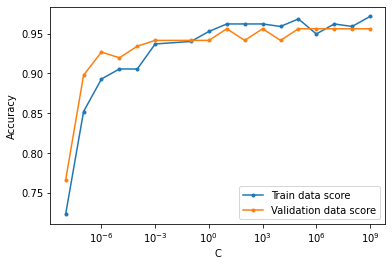

In [6]:
# plotting the model accuracy at each C value

plt.figure()
plt.plot(C_values, train_score, label='Train data score', marker='.')
plt.plot(C_values, validation_score, label='Validation data score', marker='.')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

- Based on this plot, it seems that at C = 10, the model achieved best performance.

- Using this information, we can take the test data and evaluate model's accuracy on the unseen data. For the final logistic regression with C=10, we actually retrain the model on Train+Validation data aka _remainder data_ and then get the prediction on test set

In [7]:
final_logreg = LogisticRegression(C=10, random_state=1)

# X_remainder, y_remainder held the original split data
final_logreg.fit(X_remainder, y_remainder)

# scoring on test set
final_logreg.score(X_test, y_test)

0.9736842105263158

#### Summary of the parameter optimization workflow

**Step1**: Split the original data into training and test set, keep the test set aside.

**Step2**: Split the training set further in train componet and validation component. Here train component acts as original training set and validation set act as the test set.

**Step3**: Fit the model on the train component and choose the best parameter using the validation component.

**Step4**: Using the chosen paramter, refit the model with original splitted training set and check the model's performance using the unseen test set.

### Cross-validation

- In the above implementation, I had divided the train-validation in 70-30 ratio. I could have very well chosen a different ratio split and achieved another hyperparameter. So, how we divide out data between train and validation can have an impact on the parameter seclection and hence the overall model performance. 

- In general, we can't be sure that the split we decide is going to be the optimal split to get the best parameter. So, we can try combination of every possible split. This is in reality an impractical approach, so we instead utilize **K-fold cross validation** technique.

**K-fold Cross Validation**

    - We first partition the training data into 'K' groups.
    
    - We try every division between the train and validation where train set contain K-1 of the groups while the validation set contain the 1 remaining group.
    
    - To evaluate the model, we take the 'average' over all the validation set.
    
    - Since we limit to validation sets containing only 1 group, we only have K potential splits.
    
    - Eg: for a 5-fold cross validation, the model is firred to each train set and scored on validation set for each split, generating 5 scores. The average of all 5 scores is taken as the final evaluation on the validation set.

**Implementation**

Let's use the same dataset

In [8]:
from sklearn.model_selection import cross_val_score #function to implement K-fold CV

In [9]:
# split the data to keep test set aside

X_remainder, X_test, y_remainder, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

- **We no longer to further split the training data into train+validation. cross_val_score does this automatically**

In [12]:
# Let's do a 5-fold cv

logreg = LogisticRegression(random_state=42)
score = cross_val_score(logreg, X_remainder, y_remainder, cv=5)
print(score)

[0.97802198 0.9010989  0.96703297 0.95604396 0.9010989 ]


- **This provided the score on each of the 5 validation splits. To get average score:**

In [13]:
print(f'Average score: {np.mean(score)}')

Average score: 0.9406593406593406


### K-fold cross validation for hyperparameter tuning

- To actually use cross validation for model selection and hyperparameter optimization, we need to evaluate all model resulting from changing hyperparameter values we are considering on each of the folds. The choice of hyperparameter then comes down to the value with the highest cross validation score.

In [15]:
crossvalscore = []

C_values = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,0.1,\
                1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

for value in C_values:
    
    logreg = LogisticRegression(C = value, random_state=42)
    
    #5-fold cv at each C value, generating 5 different scores
    score = cross_val_score(logreg, X_remainder, y_remainder, cv=5)
    
    #taking average score from 5 scores at each C value
    avgscore = np.mean(score)
    
    #adding the average score to the list
    crossvalscore.append(avgscore)

In [16]:
print(crossvalscore)

[0.7428571428571429, 0.8659340659340659, 0.9010989010989011, 0.9164835164835164, 0.9142857142857144, 0.9252747252747253, 0.9318681318681319, 0.9406593406593406, 0.9428571428571428, 0.9472527472527472, 0.945054945054945, 0.9472527472527472, 0.9494505494505494, 0.9494505494505494, 0.9428571428571428, 0.9428571428571428, 0.9472527472527472]


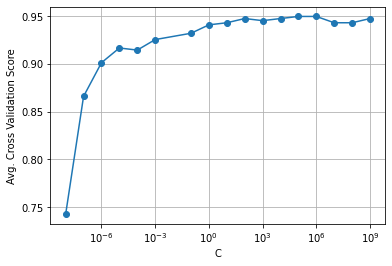

In [19]:
# plotting

plt.figure()
plt.plot(C_values, crossvalscore, marker='o')
plt.xlabel('C')
plt.ylabel('Avg. Cross Validation Score')
plt.xscale('log')
plt.grid()
plt.show();

- With 5-fold CV, the most optimal parameter to get the best score is at C = 10^5 or 1000000

- Because we've taken into consideration 5 different splits, we can be more confident that the model with this hyperparameter is the one that fits the data the best

In [20]:
# Evaluating on the test set

final_logreg = LogisticRegression(C=1000000, random_state=1)

# X_remainder, y_remainder held the original split data
final_logreg.fit(X_remainder, y_remainder)

# scoring on test set
final_logreg.score(X_test, y_test)

0.956140350877193

# PIPELINES

The general steps in creating a machine learning model:

- Get the data
- Clean the data
- Splitting the data into test and train sets
- Scaling the data
- Feature extraction and creation
- Choosing and fitting a model
- Cross-validation
- Scoring

With this number of steps, we are starting to risk mistakes - what if we accidentally mess up our splitting, and train on some of our validation data?

What happens when we want to change a step? What if we want to run it all at once every time? What if we want to carry out a parameter search on a step early in the process?

We can build a pipeline that consists of any number of transformers, and each model will be run with the 'transform' method of all steps, except with the fit of the terminal one.

Using a pipeline, we can make sure that all of our steps are carried out, with the same parameters, and in the same order.

**Implementation**

Let's use the same dataset

In [23]:
# creating a pipeline to fit scaler, dimensional reduction using logistic regression

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# we give the estimators as a list of tuples: name, function
estimators = [('scaler', StandardScaler()),
              ('PCA', PCA(n_components=2)),
              ('model', LogisticRegression())]

# creating an instance of Pipline
my_pipe = Pipeline(estimators)


- The my_pipe object transform on each object, passing the output to the next step.



In [24]:
# creating 5-fold cv

score = cross_val_score(my_pipe, X_remainder, y_remainder, cv=5)
print(f'Cross validation scores: {score}')
print(f'Average Cross validation score: {np.mean(score)}')

Cross validation scores: [0.92307692 0.93406593 0.95604396 0.94505495 0.93406593]
Average Cross validation score: 0.9384615384615385


- The final step is to use fit method to automate the entire process.

In [25]:
# fitting on the training data
my_pipe.fit(X_remainder, y_remainder)

print(f'Train score: {my_pipe.score(X_remainder, y_remainder)}')
print(f'Test score: {my_pipe.score(X_test, y_test)}')


Train score: 0.9472527472527472
Test score: 0.9912280701754386


# Grid Searching

- As models have various hyperparameters, we can use GridSearchCV function from Scikit-learn to automate the process of selecting the best hyperparameter for a particular model.

- We can also employ the pipelines to define various hyperparameters and then use the GridSearchCV to test the combination of parameters to see which will give us the best score on the metrics.

- Besides hyperparameters, this can also be used to select the best model!

**Implementation**

 - Using the same dataset, fitting a GridSearchCV using atleast two scalers, two dimensional reducers and three classifiers.

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import KernelPCA

# importing GridSearchCV
from sklearn.model_selection import GridSearchCV

 - We want to choose 3 models, 2 scalers, 2 dimensional reducers. To do this, we need to pass in the parameters to GridsearchCV as a dictionary in the format **{'stepname_param':[values]}**

In [27]:
# Create placeholder pipeline for all three steps

estimators = [('scaler', StandardScaler()),
              ('dim_reducer', PCA()),
              ('model', LogisticRegression())]

my_pipe = Pipeline(estimators)

In [30]:
# Since each model has different parameters, they each have to go in a separate dictionary

param_grid = [
{'scaler':[StandardScaler(), None],
 'dim_reducer':[PCA(), KernelPCA()],
 'model':[SVC()],
 'model__gamma':[0.001, 0.01, 0.1, 1, 10, 100],
 'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
 'dim_reducer__n_components':[2,3,4]},
{'scaler':[StandardScaler(), None],
 'dim_reducer':[PCA(), KernelPCA()],
 'model':[LogisticRegression(solver='saga')],
 'model__C':[0.001, 0.01, 0.1, 1, 10, 100],
 'model__penalty':['l1','l2'],
 'dim_reducer__n_components':[2,3,4]},
{'scaler':[StandardScaler(),None],
 'dim_reducer': [PCA(), KernelPCA()],
 'model': [DecisionTreeClassifier()], 
 'model__max_depth': [1,2,3,4],
 'model__min_samples_leaf': [2, 10],
 'dim_reducer__n_components': [2,3,4]}]

In [32]:
# instantiating GridSearchCV

grid = GridSearchCV(my_pipe, param_grid, cv=5)

- We now have a grid search object with which we can fit to our data, and find the values for multiple parameters.

In [33]:
fittedgrid = grid.fit(X_remainder, y_remainder)

- The fitted search is the best found model, based on its cross-validation score in the grid search.

- We can predict and score using the object:

In [34]:
fittedgrid.score(X_test, y_test)

0.956140350877193

- And get out the best parameters:

In [35]:
fittedgrid.best_params_

{'dim_reducer': PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
     svd_solver='auto', tol=0.0, whiten=False),
 'dim_reducer__n_components': 4,
 'model': SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
     max_iter=-1, probability=False, random_state=None, shrinking=True,
     tol=0.001, verbose=False),
 'model__C': 10,
 'model__gamma': 0.01,
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}